In [78]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from collections import defaultdict

In [79]:
# importing data
all_cell_markers_df = pd.read_csv('../data/all_cell_markers.txt', sep = r'\t')
all_human_markers_df = pd.read_csv('../data/Human_cell_markers.txt', sep = r'\t')
all_mouse_markers_df = pd.read_csv('../data/Mouse_cell_markers.txt', sep = r'\t')
all_singleCell_markers_df = pd.read_csv('../data/Single_cell_markers.txt', sep = r'\t')

/opt/anaconda3/envs/scripps_microbiome/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


# Data Schema
- **speciesType**: the species from which the data originates
    - there are only two data type, either `Human` or `Mouse`
- **tissueType**: the type of tissues from which data originates
    - in total 181 different kinds of cells
    - a lot of them are undefined
- **UberonOntologyID**: The universal unique identifier of the anatomy structure found in animals 
    - needs to confirm with the team
    - contain missing value
- **cancerType**: the association of the cell marker with the cancer name
    - no cancer cell are named as `Normal`
- **cellName**: the English name of the cell that marker belong to
- **CellOntologyID**: The universal unique identifier of the cell that marker belong to
    - contain missing value
- **cellMarker**: a marker molecule of the cell
    - in string list, can be convert to list
- **geneSymbol**: gene expression of the cell marker
- **geneID**: The universal unique identifier of the gene
    - contain missing value
- **proteinName**: name of the protein
    - contain missing value
- **proteinID**: The universal unique identifier of the protein
- **markerResource**: the type of resouce or methologoy used to identify the marker
    - there are only four data type, either `Experiment` or `Single-cell sequencing` or `Company` or `Review`
- **PMID**: The PudMed ID for the publication or study where the marker data was reported
    - abnormal value contain `company`
- **Company**: the company associated with the resouces

# Missingness of the vlaues

In [80]:
all_cell_markers_df.isna().mean()

speciesType         0.000000
tissueType          0.000000
UberonOntologyID    0.180936
cancerType          0.000000
cellType            0.000000
cellName            0.000000
CellOntologyID      0.210526
cellMarker          0.000000
geneSymbol          0.012127
geneID              0.012127
proteinName         0.013582
proteinID           0.013582
markerResource      0.000000
PMID                0.000000
Company             0.913898
dtype: float64

# Exploration on all_cell_markers
Notes: all codes a modulerized, which means you can directly jump to a specific section without running previous sections

EDA outlines:
- Confirming hypothesis: `all_cell_markers` contain all the data from `all_human_markers`, `all_mouse_markers`
- Confirming hypothesis: None of the data from `all_singleCell_markers` exist in `all_cell_markers`
- Revealing trend: assoication between missing `UberonOntologyID` and `tissueType`
- Revealing trend: assoication between missing `CellOntologyID` and `cellName`
- Confirming hypothesis: if `geneSymbol` is missing, then `geneID` is not missing
- Confirming hypothesis: if `proteinName` is missing, then `proteinID` is not missing
- Revealing trend: find the the pattern of the mistached elements of all the list-like str columns
- Confirming hypothesis: if markerResource is `company`, then `PMID` is company and `Company` is not missing

## Confirm Hypothesis
`all_cell_markers` contain all the data from `all_human_markers`, `all_mouse_markers`

In [81]:
all_cell_marker_tuple = all_cell_markers_df.apply(tuple, axis=1)
all_human_marker_tuple = all_human_markers_df.apply(tuple, axis=1)
all_mouse_markers_tuple = all_mouse_markers_df.apply(tuple, axis=1)

# check if all value in human_marker exist in cell_marker
if all(all_human_marker_tuple.isin(all_cell_marker_tuple)):
    print("all value in all_human_marker dataset exist in all_cell_marker dataset")
else:
    mismatch_value = sum(all_human_marker_tuple.isin(all_cell_marker_tuple) == False)
    print(f"there are {mismatch_value} from all_human_marker that does not exist in all_cell_marker dataset")

# check if all value in mouse_marker exist in cell_marker
if all(all_mouse_markers_tuple.isin(all_cell_marker_tuple)):
    print("all value in all_mouse_markers dataset exist in all_cell_marker dataset")
else:
    mismatch_value = sum(all_mouse_markers_tuple.isin(all_cell_marker_tuple) == False)
    print(f"there are {mismatch_value} from all_mouse_markers that does not exist in all_cell_marker dataset")



all value in all_human_marker dataset exist in all_cell_marker dataset
all value in all_mouse_markers dataset exist in all_cell_marker dataset


## Confirm Hypothesis
None of the data from `all_singleCell_markers` exist in `all_cell_markers`

In [82]:
all_cell_marker_tuple = all_cell_markers_df.apply(tuple, axis=1)
all_singleCell_markers_tuple = all_singleCell_markers_df.apply(tuple, axis=1)

# check if all value in singleCell_marker exist in cell_marker
if all(all_singleCell_markers_tuple.isin(all_cell_marker_tuple)):
    print("all value in all_singleCell_markers dataset exist in all_cell_marker dataset")
else:
    mismatch_value = sum(all_singleCell_markers_tuple.isin(all_cell_marker_tuple) == False)
    print(f'there are in total {mismatch_value} records in all_singleCell_markers')
    print(f"there are {mismatch_value} from all_singleCell_markers that does not exist in all_cell_marker dataset")

there are in total 535 records in all_singleCell_markers
there are 535 from all_singleCell_markers that does not exist in all_cell_marker dataset


## Revealing trend
assoication between missing `UberonOntologyID` and `tissueType`

most of the tissue with missing ID is undefined tissue

In [83]:
cell_markers_df = pd.concat([all_cell_markers_df, all_singleCell_markers_df], axis = 0, ignore_index=True)
cell_markers_df[['UberonOntologyID', 'tissueType']][cell_markers_df['UberonOntologyID'].isna()].tissueType.value_counts()

Undefined                      701
Fetal liver                     29
Fetal gonad                     26
Embryonic prefrontal cortex     12
Bladder                          5
Sinonasal mucosa                 2
Fetal brain                      1
Osteoarthritic cartilage         1
Name: tissueType, dtype: int64

# Revealing trend
assoication between missing `CellOntologyID` and `cellName`

In [84]:
cell_markers_df = pd.concat([all_cell_markers_df, all_singleCell_markers_df], axis = 0, ignore_index=True)
cell_markers_df[['CellOntologyID', 'cellName']][cell_markers_df['CellOntologyID'].isna()].cellName.value_counts()

Cancer stem cell                    596
Progenitor cell                      53
Cancer stem-like cell                 9
Neural progenitor cell                8
Cardiac progenitor cell               8
                                   ... 
Foxp3+IL-17+ T cell                   1
Definitive zone cell                  1
Bone marrow stem cell                 1
PDX1+ pancreatic progenitor cell      1
Adipogenic progenitor cell            1
Name: cellName, Length: 142, dtype: int64

# Confirming hypothesis
if `geneSymbol` is missing, then `geneID` is not missing

In [85]:
cell_markers_df = pd.concat([all_cell_markers_df, all_singleCell_markers_df], axis = 0, ignore_index=True)
check_same = cell_markers_df[['geneSymbol', 'geneID']].apply(
    lambda row: all(row.isna()) or all(~row.isna()), axis = 1 
)
if all(check_same):
    print('if there is a missing proteinSymbol, then there must be missing proteinID')
else:
    print('if there is a missing symbol then there might exist a ID')

if there is a missing proteinSymbol, then there must be missing proteinID


# Confirming hypothesis
if `proteinName` is missing, then `proteinID` is not missing

In [86]:
cell_markers_df = pd.concat([all_cell_markers_df, all_singleCell_markers_df], axis = 0, ignore_index=True)
check_same = cell_markers_df[['proteinName', 'proteinID']].apply(
    lambda row: all(row.isna()) or all(~row.isna()), axis = 1 
)
if all(check_same):
    print('if there is a missing proteinSymbol, then there must be missing proteinID')
else:
    print('if there is a missing symbol then there might exist a ID')

if there is a missing proteinSymbol, then there must be missing proteinID


## Revealing Trend
find the the pattern of the mistached elements of all the list-like str columns

In [87]:
cell_markers_df = pd.concat([all_cell_markers_df, all_singleCell_markers_df], axis = 0, ignore_index=True)
def str_to_list(listLikeStr):
    if not isinstance(listLikeStr, str): return ['NA']
    cleaned_listLikeStr = listLikeStr.replace("'", "")

    split_element = cleaned_listLikeStr.split(',')

    is_nested = False
    result = []
    nested_list = []

    # try to improve
    for element in split_element:
        if is_nested:
            if "]" in element:
                is_nested = False
                element = element.replace(']', "").strip()
                # lowercase
                # if element.casefold() == 'na':
                #     continue
                nested_list.append(element)
                result.append(nested_list)
                nested_list = []
            else:
                element = element.strip()
                # if element.casefold() == 'na':
                #     continue
                if element:
                    nested_list.append(element.strip())
        else:
            if "[" in element:
                is_nested = True
                element = element.replace('[', "").strip()
                # if element.casefold() == 'na':
                #     continue
                nested_list.append(element)
            else:
                element = element.strip()
                # if element.casefold() == 'na':
                #     continue
                if element:
                    result.append(element)

    return result
        

to_convert_col  = ['cellMarker', 'geneSymbol', 'geneID', 'proteinName', 'proteinID']


for col in to_convert_col:
    cell_markers_df[col] = cell_markers_df[col].apply(str_to_list)

len_count = cell_markers_df[to_convert_col].applymap(len)

if cell_markers_df[to_convert_col].applymap(lambda x: len(x) if isinstance(x, list) else np.NaN).dropna().shape[0] == 0:
    print("each existed cellMarkers have a gene name assoicated it")
else:
    print('some gene has mis-match sequence')
    mistamch_index = len_count[len_count.nunique(axis = 1) != 1].index
    print(f"for these following index: {mistamch_index}")

some gene has mis-match sequence
for these following index: Int64Index([3135, 3151, 3226, 3227, 3228, 3243, 3632, 3710, 3733, 3741, 3844,
            3908, 3973, 3977, 3983, 4005, 4099, 4167, 4245, 4268, 4276, 4379,
            4443, 4508, 4512, 4518, 4540, 4634],
           dtype='int64')


In [88]:
mistach_cell_markers = cell_markers_df.loc[mistamch_index]
mt_mr_dis = mistach_cell_markers.markerResource.value_counts(normalize=True)

In [89]:
mistach_cell_markers.shape[0] #/ cell_markers_df.shape[0] * 100

28

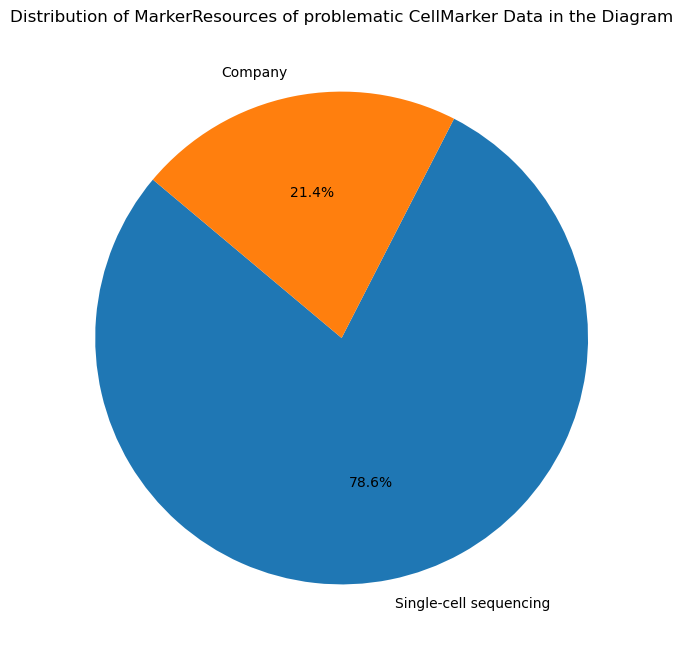

In [90]:
plt.figure(figsize=(8, 8))
plt.pie(mt_mr_dis, labels=mt_mr_dis.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of MarkerResources of problematic CellMarker Data in the Diagram')
plt.show()

In [91]:
# Examples of mismatch
cell_markers_df.loc[3973] # additional NA at the end
cell_markers_df.loc[3741] # total mismatch
cell_markers_df.loc[3710] # total mismatch
;

''

## Confirming hypothesis
if markerResource is `company`, then `PMID` is company and `Company` is not missing

In [92]:
cell_markers_df = pd.concat([all_cell_markers_df, all_singleCell_markers_df], axis = 0, ignore_index=True)

cell_marker_iscompany = cell_markers_df[['markerResource', 'PMID', 'Company']].assign(is_company = cell_markers_df['markerResource'] == 'Company')

# if is_company is false, then should PMID should not be company and Company is should be NaN
for row in cell_marker_iscompany.iterrows():
    row = row[1]
    if row[-1]:
        if row[1] == "Company" and pd.notna(row[2]):
            continue
        else:
            print(row)
    else:
        if row[1] != "Company" and pd.isna(row[2]):
            continue
        else:
            print(row)
print('all row match the expected format')

all row match the expected format


# Parsing procedure

Data Parsing Outlines
- concat `all_cell_markers` and `all_singleCell_markers`
- replace all the `undefined` tissue to NaN value
- convert all the strLikelist into list
- remove all rows with missing geneID

In [93]:
# importing dataframe
all_cell_markers_df = pd.read_csv('../data/all_cell_markers.txt', sep = r'\t')
all_human_markers_df = pd.read_csv('../data/Human_cell_markers.txt', sep = r'\t')
all_mouse_markers_df = pd.read_csv('../data/Mouse_cell_markers.txt', sep = r'\t')
all_singleCell_markers_df = pd.read_csv('../data/Single_cell_markers.txt', sep = r'\t')

In [94]:
def str_to_list(listLikeStr):
    if not isinstance(listLikeStr, str): return ['NA']
    cleaned_listLikeStr = listLikeStr.replace("'", "")

    split_element = cleaned_listLikeStr.split(',')

    is_nested = False
    result = []
    nested_list = []

    # try to improve
    for element in split_element:
        if is_nested:
            if "]" in element:
                is_nested = False
                element = element.replace(']', "").strip()
                # lowercase
                # if element.casefold() == 'na':
                #     continue
                nested_list.append(element)
                result.append(nested_list)
                nested_list = []
            else:
                element = element.strip()
                # if element.casefold() == 'na':
                #     continue
                if element:
                    nested_list.append(element.strip())
        else:
            if "[" in element:
                is_nested = True
                element = element.replace('[', "").strip()
                # if element.casefold() == 'na':
                #     continue
                nested_list.append(element)
            else:
                element = element.strip()
                # if element.casefold() == 'na':
                #     continue
                if element:
                    result.append(element)

    return result

In [95]:
# concatnating all_cell_markers and all_singleCell_markers
cell_markers_df = pd.concat([all_cell_markers_df, all_singleCell_markers_df], axis = 0, ignore_index=True)

# dropping column proteinName and proteinID
cell_markers_df.drop(columns=['proteinName', 'proteinID'], inplace=True)

# we don't consider record with missing geneID
cell_markers_df = cell_markers_df.dropna(subset=['geneID'])

# change all the Undefined value in tissueType column to NaN
cell_markers_df['tissueType'] = cell_markers_df['tissueType'].replace('Undefined', np.NaN)

# convert specific columns into list
to_convert_col  = ['cellMarker', 'geneSymbol', 'geneID']
for col in to_convert_col:
    cell_markers_df[col] = cell_markers_df[col].apply(str_to_list)


In [98]:
raise ValueError()

ValueError: 

## Play ground

In [102]:
x = cell_markers_df[cell_markers_df[['cellMarker', 'geneSymbol', 'geneID']].applymap(len).nunique(axis=1) != 1]

In [105]:
x[['cellMarker', 'geneSymbol', 'geneID']].applymap(len)

,cellMarker,geneSymbol,geneID
3151,36,35,35
3226,20,21,21
3227,20,21,21
3228,20,21,21
3632,13,12,13
3844,454,465,454
3983,252,252,277
4005,98,97,98
4099,200,190,190
4167,13,12,13


In [19]:
def flatten_list(nested_list):
    return [item for sublist in nested_list for item in (sublist if isinstance(sublist, list) else [sublist]) if item != 'NA']
geneID_dict = defaultdict(dict)



for _, row in cell_markers_df[['cellMarker', 'geneSymbol', 'geneID', 'proteinName', 'proteinID']].iterrows():
    

    for cellMarker, geneSymbol, geneID, proteinName, proteinID in zip(*[flatten_list(ele) for ele in row]):
        
        cur_gene_dict = geneID_dict[geneID]
        
        # geneSymbol: unique to the geneID
        if 'geneSymbol' in cur_gene_dict:
            cur_gene_dict['geneSymbol'].add(geneSymbol)
        else:
            cur_gene_dict['geneSymbol'] = {geneSymbol}

        # assoicate protein
        if 'associate_protein' in cur_gene_dict:
            cur_gene_dict['associate_protein'].add((proteinID, proteinName))
        else:
            cur_gene_dict['associate_protein'] = {(proteinID, proteinName)}

        # associate cellMarker
        if 'associate_cellMarker' not in cur_gene_dict:
            cur_gene_dict['associate_cellMarker'] = dict()

        cur_gene_dict['associate_cellMarker'][cellMarker] = {'info1': 'content1'}


        



In [ ]:
geneID_dict

defaultdict(dict,
            {'248': {'geneSymbol': {'ALPI'},
              'associate_protein': {('P09923', 'PPBI')},
              'associate_cellMarker': {'Intestinal Alkaline Phosphatase': {'info1': 'content1'},
               'ALPI': {'info1': 'content1'}}},
             '6855': {'geneSymbol': {'SYP'},
              'associate_protein': {('P08247', 'SYPH')},
              'associate_cellMarker': {'Synaptophysin': {'info1': 'content1'},
               'SYP': {'info1': 'content1'},
               'SRP72': {'info1': 'content1'}}},
             '634': {'geneSymbol': {'CEACAM1'},
              'associate_protein': {('P13688', 'CEAM1'),
               ('Q8N726', 'ARF'),
               ('Q8WWK9', 'CKAP2')},
              'associate_cellMarker': {'CEACAM1': {'info1': 'content1'},
               'CD66a': {'info1': 'content1'},
               'CD43': {'info1': 'content1'},
               'CD83': {'info1': 'content1'},
               'CDKN2A': {'info1': 'content1'}}},
             '54514': 

In [21]:
def test(row):
    record_dict = dict()
    for index, value in row.iteritems():
        if len(value) == 1 and value[0] == 'NA':
            continue
        record_dict[index] = value

    return record_dict

# test(pd.Series(data=[np.NAN, 1, 2, np.NaN], index=['a', 'b', 'c', 'd']))
x = cell_markers_df[['cellMarker', 'geneSymbol', 'geneID', 'proteinName', 'proteinID']].apply(test, axis = 1)